## TP1 - Léa Heiniger

In [1]:
## Imports
import numpy as np
import math
from random import random
import matplotlib.pyplot as plt

In [2]:
# local fitness functions f_K for K = 0, 1, 2 (Table in TP)
f = {
    0: {
        '0': 2,
        '1': 1
    },
    1: { 
        '00': 2,
        '01': 3,
        '10': 2,
        '11': 0
    },
    2: {
        '000': 0,
        '001': 1,
        '010': 1,
        '011': 0,
        '100': 2,
        '101': 0,
        '110': 0,
        '111': 0
    }
}

In [3]:
def generate_sequence(N):
    '''
    generates an N random bits (0, 1) sequence

    Parameters:
    -----------
    N : number of bits in the sequence

    Returns:
    --------
    sequence: sequence of N bits
    '''
    listS = [str(math.floor(random()+0.5)) for i in range(N)]
    sequence = "".join(listS)

    return sequence


def compute_fitness(sequence, K): 
    '''
    computes the fitness of sequence, with respect to K, according to table f

    Parameters:
    -----------
    sequence : N-bits sequence
    K : parameter K (0, 1, or 2)

    Returns:
    --------
    fitness: fitness value of sequence
    '''
    fitness= 0
    for i in range(len(sequence)-K) :
        chain = sequence[i:i+1+K]
        fitness += f[K][chain]

    return fitness


def neighbors(sequence):
    '''
    Function creating a list of neighbors

    Parameters :
     sequence -> sequence of bits

    Returning :
     n -> the list of all the neighbors of sequence
    '''
    N = len(sequence)
    n = []
    for i in range(N) :
        invert = str(np.abs(int(sequence[i]) - 1))
        x = sequence[:i] + invert + sequence[i + 1:] # we change only one bit in X for each neighbor
        n.append(x)

    return n

def mean_steps(samples):
    ''' 
    returns mean of steps taken to find solution (for deterministic)

    Parameters:
    -----------
    samples : samples of deterministic_hillclimb runs

    Returns:
    --------
    mean steps
    '''
    # get mean of steps needed to find solution (sum of samples' steps/number of samples)
    s = 0
    s += sum([samples[i][2] for i in range(len(samples))])
    return s/len(samples)


def generate_samples(hillclimb_method, K):
    ''' 
    generates 50 samples (solutions) for the hillclimb method (deterministic/probabilistic)

    Parameters:
    -----------
    hillclimb_method : deterministic_hillclimb/probabilistic_hillclimb
    K : parameter K (0, 1, or 2)

    Returns:
    --------
    generator of samples/solutions (sequence, fitness, number of steps)
    '''
    if K not in [0, 1, 2]:
        raise Exception("Invalid K")

    # run for 50 times to get 50 samples/solutions
    for i in range(50):
        # generate initial sequence
        initial_sequence = generate_sequence(N=21)
        # get solution, its fitness, number of steps taken to find solution
        x, f_x, s = hillclimb_method(initial_sequence, K)
        yield (x, f_x, s)

In [4]:
def bestNeighbor(n, K) : 
    '''
    Function returning the best neighbor (deterministic)

    Parameters :
     n -> the list of all the neighbors of a sequence X
     K -> degree parameter

    Returning :
      the best neighbor
      maximum -> its fitness
    '''
    maximum = -1
    best = 0
    for i in range(len(n)) :
        nFitness = compute_fitness(n[i], K)
        if nFitness > maximum : # best neighbor is the one withe the highest fitness
            maximum = nFitness
            best = i
   
    return n[best], maximum

def deterministic_hillclimb(sequence, K): 
    ''' 
    performs deterministic_hillclimb

    Parameters:
    -----------
    sequence : N-bits sequence
    K : parameter K (0, 1, or 2)

    Returns:
    --------
    sequence : optimal/fittest sequence found
    max_fitness : fitness value of sequence
    steps: steps it took to reach optimum 
    '''
    steps = 0
    fitness = compute_fitness(sequence, K)
    n = neighbors(sequence)
    while True :
        newS, newSFitness = bestNeighbor(n, K)
        steps += 1
        if newSFitness > fitness :
            sequence = newS
            fitness = newSFitness
            n = neighbors(sequence)
        else : 
            break
            
    max_fitness = fitness
    return sequence, max_fitness, steps

# dictionary to save deterministic_hillclimb samples (sequence, max_fitness, steps)
deterministic_samples = {}
# dictionary to save number of steps to perform probabilistic hillclimb 
probabilistic_steps = {}


# run deterministic_hillclimb, get mean steps
for K in [0, 1, 2]:
    # for each K, generate 50 deterministic_hillclimb solutions, and save them
    deterministic_samples[K] = list(generate_samples(deterministic_hillclimb, K))
    # for each K, save the number of steps to take (10*mean steps taken for deterministic_hillclimb)
    probabilistic_steps[K] = 10*round(mean_steps(deterministic_samples[K]))

In [5]:
def rouletteMethod(P) :
    '''
    Function implementing the roulette method

    Parameters :
     P -> the probability of obtaining each event

    Returning :
     The event obtained
    '''
    Pcumul = [sum(P[0:x:1]) for x in range(0, len(P)+1)]
    Pcumul.pop(0)
    r = random()
    for i in range(len(Pcumul)) :

        if Pcumul[i] > r :

            return i
        
def probaBestNeighbor(n, K, bestFitness) :
    '''
    Function finding the best neighbor with the probabilistic alogorithm

    Parameters :
     n -> the list of all the neighbors of a sequence X
     K -> degree parameter
     bestFitness -> the best fitness found at this point

    Returning :
      maximum -> the fitness of the best neighbors
      best -> the best neighbor
      (or)
      proba -> the list of proba of each neighbor
    '''
    neighborsFitness = [compute_fitness(i, K) for i in n]
    maximum = np.max(neighborsFitness)
    if maximum > bestFitness : # deterministic
        best = n[np.argmax(neighborsFitness)]
        proba = [] # no use of proba

    else : # probabilistic
        best = None #no best neighbor found yet
        proba = neighborsFitness / np.sum(neighborsFitness)

    return maximum, best, proba

def probabilistic_hillclimb(sequence, K):
    # TODO
    ''' 
    performs probabilistic_hillclimb

    Parameters:
    -----------
    sequence : N-bits sequence
    K : parameter K (0, 1, or 2)

    Returns:
    --------
    sequence : optimal/fittest sequence found
    max_fitness : fitness value of sequence
    steps: steps corresponding to parameter K
    '''
    steps = 0
    fitness = compute_fitness(sequence, K)
    n = neighbors(sequence)
    listS = [sequence]
    listFitness = [fitness]
    bestFitness = fitness
    for _ in range(probabilistic_steps[K]) : # we stop after a fixed number of steps
        maximum, best, proba = probaBestNeighbor(n, K, bestFitness)
        if len(proba) == 0 : # we found a new maxima fitness
            bestFitness = maximum
            sequence = best

        else : # we didn't found a new maimal fitness
            p = rouletteMethod(proba) # we use the roulette method to choose a neighbor
            sequence = n[p-1]

        listS.append(sequence)
        listFitness.append(compute_fitness(sequence, K))
        n = neighbors(sequence)

        sequence = listS[np.argmax(listFitness)]
        steps += 1
        
    max_fitness = compute_fitness(sequence,K)

    return sequence, max_fitness, steps

# dictionary to save probabilistic_hillclimb samples (sequence, max_fitness, steps)
probabilistic_samples = {}


# run probabilistic_hillclimb
for K in [0, 1, 2]:
    # for each K, generate 50 probabilistic_hillclimb solutions, and save them
    probabilistic_samples[K] = list(generate_samples(probabilistic_hillclimb, K))

In [6]:
def hamming_distance(sequence1, sequence2):
    ''' 
    returns hamming distance between sequence1 and sequence2

    Parameters:
    -----------
    sequence1 : N-bits sequence
    sequence2 : N-bits sequence

    Returns:
    --------
    distance : hamming distance between sequence1 and sequence2
    '''
    distance = 0
    for i in range(len(sequence1)):
        if sequence1[i] != sequence2[i]:
            distance += 1
    return distance

def compute_hamming_distencies(samplesDict, K) :
    '''
    Function that compute the hamming distencies between all samples pairwise
    
    Parameters :
     samplesDict -> dictonary that contains all the sampels
     K -> the degree parameter 
     
    Returning :
     hammingDist -> a list of all the hamming distencies
    '''
    
    hammingDist = []
    for i in range(len(samplesDict[K])) :
        for j in range(i+1,len(samplesDict[K])) :
        
            hammingDist.append(hamming_distance(samplesDict[K][i][0], samplesDict[K][j][0]))
    
    return hammingDist


In [7]:
# A function usefull to plot the results

def plot_hammingDist(hammingDist, methode, K):
    '''
    Function that plots the histogram of hamming distances
    
    Parameters :
     hammingDist -> a list of all hamming distances computed pairwise
     methode -> a string of the name of the methode used (deterministic or probabilistic)
     K -> the degree parameter used
    '''
    
    n, bins, patches = plt.hist(hammingDist, np.unique(hammingDist), color = "tab:blue", alpha = 0.5, histtype = 'bar', ec = 'black')

    strTitle = methode + " hill-climbing, K = " + str(K)
    plt.title(strTitle)
    plt.xlabel('Hamming distance')
    plt.ylabel('Number of times')

    plt.show()


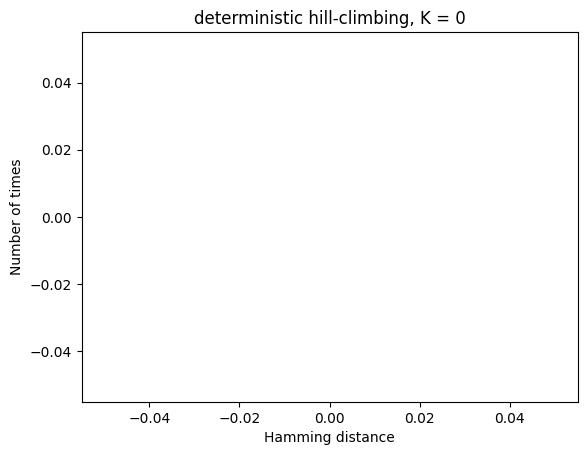

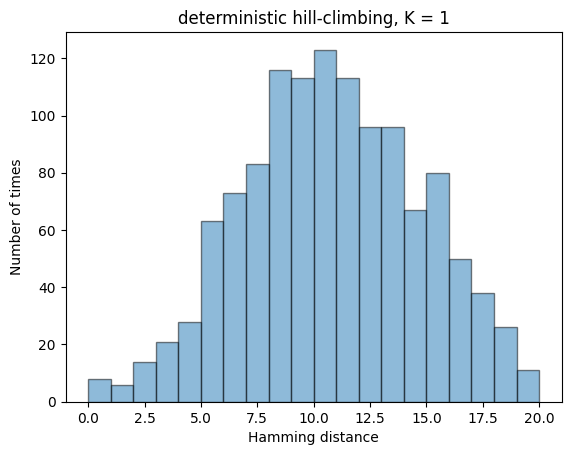

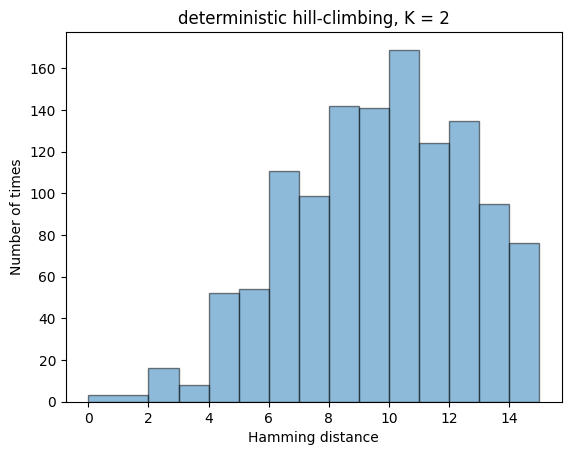

In [8]:
## TODO : Plot and analyze pairwise hamming distances for all methods and K values

''' Deterministic '''
for K in [0,1,2] :

    hammingDist = compute_hamming_distencies(deterministic_samples, K)
    plot_hammingDist(hammingDist, 'deterministic', K)


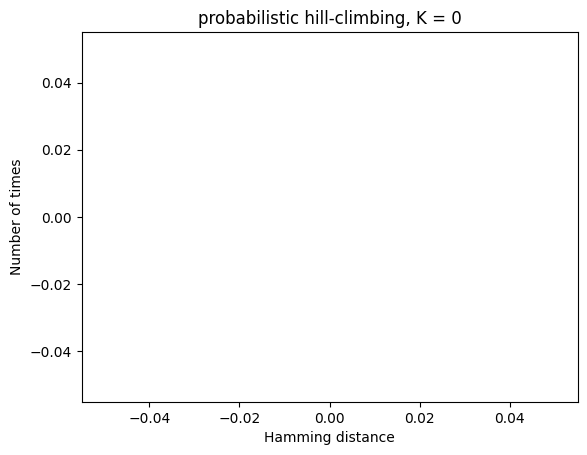

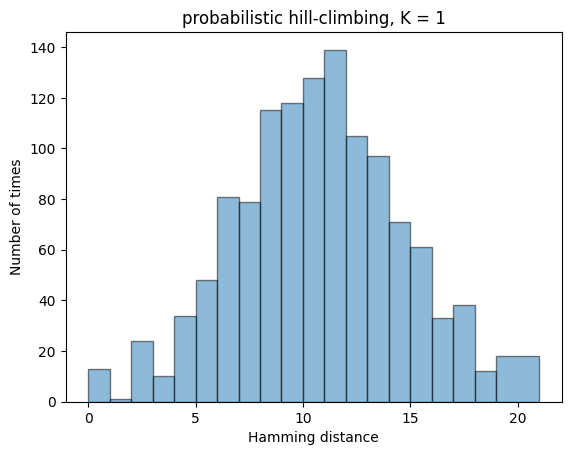

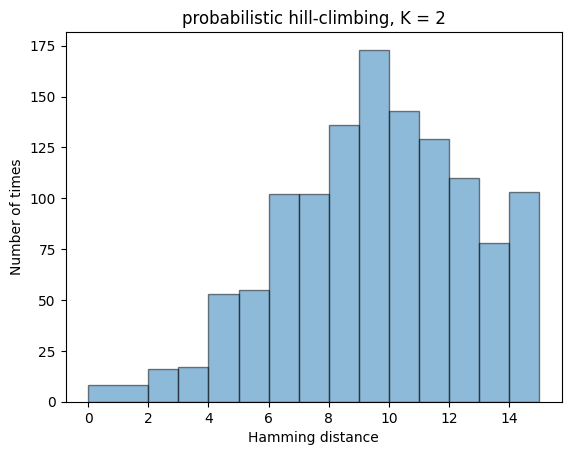

In [9]:
''' Probabilistic '''
for K in [0,1,2] :

    hammingDist = compute_hamming_distencies(probabilistic_samples, K)
    plot_hammingDist(hammingDist, 'probabilistic', K)


In [10]:
## TODO : discuss the behaviour and the performance (in terms of the quality of the solutions) of each exploration method.

# **Results discusion**  
  
Looking at the histograms of hamming distances we can see that both algorithms found the global maximum when K = 0. Since there is only one maximum the deterministic algorithm can't be stuck at a local maximum so it always finds the global maximum. And for the probabilistic algorithm we made sure (with the aspiration) to explore a sequence with a higher fitness if we didn't see one as good previously. Therefore those results were expected.  
For K = 1 and K = 2 there is not much differnencies between the histograms of both algorithms. We can see that the bins are slightly more even with the probabilistic methode but we can't definitly tell that this methode is better for those K since they show a similar gaussian distribution for a same value of K and the difference is so small.  

In [11]:
## TODO : Answer the questions from TP 

# **Questions**  
  
**1. What is the roughness of the landscape ?**  
The roughness of the landscape is how mutch our landscape has local maximums and minimums, the higher the degree K the rougher the landscape. In general the deterministic method tends to do better on landscapes with a small roughness (less chances to be stuck on a local maximum) and are quicker than the probabilistic method for that kind of landscape. On the contrary the probabilistic algorithm has better results on landscapes with a high roughness, therfore it is worth the small loss of speed in computation.  
  
**2. What is the research space of the employed optimization methods ?**  
For a N-bits string we have a search space of {0,1}^N  
  
**3. How are the two methods different ?**  
The main difference between the two algorithms is the way to choose the next sequence. In the deterministic algorithm we always compare all the neighbors and then we choose the best one, but in the probabilistic algorithm we choose randomly between the neighbors. This difference explains why the deterministic algorithm has more chances to get stuck in a local maximum.  
  
**4. What is the neighborhood of an element of the research space ?**  
The neighborhood of a sequence s in {0,1}^N is the set of sequences s' in {0,1}^N that are at a hamming distance of 1 from s. In other words the neighborhood of a sequence is the set of sequences that vary from s only by one bit.  
  
**5. Is the solution of the optimization an element belonging to the research space or the fitness space ?**  
The solution of the optimization belongs to the research space since we want to find the  sequence that maximise the fitness function and not just the maximum fitness value.